In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import math
from datetime import datetime

In [2]:
## getting the data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
## checking for missing
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [5]:
## checking the keyword column
df_train["keyword"].value_counts()

keyword
fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: count, Length: 221, dtype: int64

In [6]:
df_train[df_train["location"].notna()]

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
...,...,...,...,...,...
7575,10826,wrecked,TN,On the bright side I wrecked http://t.co/uEa0t...,0
7577,10829,wrecked,#NewcastleuponTyne #UK,@widda16 ... He's gone. You can relax. I thoug...,0
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0
7580,10832,wrecked,London,#FX #forex #trading Cramer: Iger's 3 words tha...,0


In [7]:
## checking the nature of the tweets

df_train["text"].sample(5).values

array(['Steve Buscemi was a firefightr B4 fame &amp; workd 12hr shifts diggin thru WTC rubble lookg 4 survivors. http://t.co/L9fJpNSZuO',
       'No #news of #hostages in #Libya\n\nhttp://t.co/bjjOIfzUhL\n\n#India #terrorism #Africa #AP #TS #NRI #News #TRS #TDP #BJP http://t.co/IywZAlLsN4',
       'Tips to prevent basement leaks - Create control joints to eliminate random cracking. #homeimprovement #Flooding http://t.co/Kx8cU4s8T1',
       '#nowplaying Sinking Fast - Now or Never on North East Unsigned Radio listen at http://t.co/QymAlttvZp',
       'Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) - http://t.co/c5u9qshhnb'],
      dtype=object)

In [8]:
## for cleaning function
## - remove urls
## - remove # tags
## - remove html special characters eg &amp;
## - remove @text
## - remove [01:04 UTC]
## - strip

In [9]:
import re

## function to preprocessing of text
def process_text(text):
    ## patterns to remove
    rem_pat_1 = "([#@]|https?:)\S*"
    rem_pat_2 = "&\S+;"
    rem_pat_3 = "\[\d+:\d+.+\]" ## removing timestamp. eg. [01:04 UTC]
    rem_pat_4 = "[\-_.+]" ## to remove symbols (make sure to bring last to avoid affecting first two patterns)
    combined_rem_pat = f"({rem_pat_1})|({rem_pat_2})|({rem_pat_3})|({rem_pat_4})"

    text = re.sub(combined_rem_pat, "", text) ## removing text that match patterns
    text = text.strip() ## removing trailing white spaces
    text = text.lower() ## lowercasing

    return text

## function for tokenizing of string
def tokenize(text):
    return re.split("\s+", text)

In [10]:
## getting the training and testing processed data
## train
train_text = df_train["text"].apply(lambda x: tokenize(process_text(x))).values
train_target = df_train["target"].values

## test
test_text = df_test["text"].apply(lambda x: tokenize(process_text(x))).values

In [11]:
train_text

array([list(['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'may', 'allah', 'forgive', 'us', 'all']),
       list(['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']),
       list(['all', 'residents', 'asked', 'to', "'shelter", 'in', "place'", 'are', 'being', 'notified', 'by', 'officers', 'no', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected']),
       ..., list(['m194', '?5km', 's', 'of', 'volcano', 'hawaii']),
       list(['police', 'investigating', 'after', 'an', 'ebike', 'collided', 'with', 'a', 'car', 'in', 'little', 'portugal', 'ebike', 'rider', 'suffered', 'serious', 'nonlife', 'threatening', 'injuries']),
       list(['the', 'latest:', 'more', 'homes', 'razed', 'by', 'northern', 'california', 'wildfire', 'abc', 'news'])],
      dtype=object)

In [12]:
## creating word dictionary
word2idx = {"<pad>": 0}
count = 1

for l in train_text:
    for i in range(len(l)):
        if l[i] not in word2idx:
            word2idx[l[i]] = count
            count+=1

        l[i] = word2idx[l[i]]

In [13]:
## function to convert token list to integer list
def token_to_int(text_data, word2idx):
    for i in range(len(text_data)):
        idx_list = []
        for word in text_data[i]:
            if word in word2idx:
                idx_list.append(word2idx[word])
        text_data[i] = idx_list

In [14]:
# ## converting text token list to index list
# token_to_int(test_text, word2idx)

In [15]:
## creating train and validation data
X_train, X_test, y_train, y_test = train_test_split(train_text, train_target, test_size=0.3, shuffle=True)

In [16]:
## creating data loaders
def data_loader(inputs, targets, batch_size=64):
    inputs, targets = shuffle(inputs, targets)
    n = len(inputs)
    num_batches = math.ceil(n/batch_size)

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx+batch_size, n)

        ## getting the batch data
        inputs_batch = inputs[start_idx:end_idx]
        targets_batch = targets[start_idx:end_idx]

        ## padding the inputs
        max_len = max([len(l) for l in inputs_batch])

        for j in range(len(inputs_batch)):
            pad_len = max_len - len(inputs_batch[j])
            inputs_batch[j] = [0]*pad_len + inputs_batch[j]

        yield np.array([*inputs_batch]),  targets_batch.reshape(-1,1).astype(np.float32)

In [17]:
batch_size = 128
train_loader = lambda: data_loader(X_train, y_train, batch_size=batch_size)
test_loader = lambda: data_loader(X_test, y_test, batch_size=batch_size)

In [18]:
## creating model
class Model(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super(Model, self).__init__()
        self.V = vocab_size
        self.D = embed_size
        self.M = hidden_size
        self.L = num_layers
    
        self.embed = nn.Embedding(self.V, self.D)
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True
        )
    
        self.fc = nn.Linear(self.M, 1)

    def forward(self, X):
        c0 = torch.zeros(self.L, X.size(0), self.M)
        h0 = torch.zeros(self.L, X.size(0), self.M)

        out = self.embed(X)

        out, _ = self.rnn(out, (c0,h0))
        out, _ = torch.max(out, 1)

        out = self.fc(out)

        return out

In [19]:
model = Model(len(word2idx), 10, 15,1)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [21]:
model.to(device)

Model(
  (embed): Embedding(17264, 10)
  (rnn): LSTM(10, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [22]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [23]:
## creating training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=50):
    train_losses = []
    test_losses = []
    
    for it in range(epochs):
        t0 = datetime.now()

        epoch_losses = []
        for inputs, targets in train_loader():
            inputs = torch.from_numpy(inputs).to(device)
            targets = torch.from_numpy(targets).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        train_losses.append(np.mean(epoch_losses))
            
        epoch_losses = []
        for inputs, targets in test_loader():
            inputs = torch.from_numpy(inputs).to(device)
            targets = torch.from_numpy(targets).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            epoch_losses.append(loss.item())

        test_losses.append(np.mean(epoch_losses))

        dt = datetime.now() - t0

        print(f"Epoch: {it+1}/{epochs}, Train Loss: {train_losses[it]}, Test Loss: {test_losses[it]}, Duration: {dt}")

    return train_losses, test_losses

In [24]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=12)

Epoch: 1/12, Train Loss: 0.6827932269800276, Test Loss: 0.6804290182060666, Duration: 0:00:00.783365
Epoch: 2/12, Train Loss: 0.6789096168109349, Test Loss: 0.6766829358206855, Duration: 0:00:00.668020
Epoch: 3/12, Train Loss: 0.6721508446193877, Test Loss: 0.669143772787518, Duration: 0:00:00.613995
Epoch: 4/12, Train Loss: 0.6596340934435526, Test Loss: 0.6563464204470316, Duration: 0:00:00.547001
Epoch: 5/12, Train Loss: 0.6366144063926878, Test Loss: 0.6371651987234751, Duration: 0:00:00.582996
Epoch: 6/12, Train Loss: 0.6045281021367936, Test Loss: 0.6169321305221982, Duration: 0:00:00.546998
Epoch: 7/12, Train Loss: 0.5728640953699747, Test Loss: 0.6028033428721957, Duration: 0:00:00.556002
Epoch: 8/12, Train Loss: 0.5433542522646132, Test Loss: 0.5943635933929019, Duration: 0:00:00.548998
Epoch: 9/12, Train Loss: 0.5172765716200783, Test Loss: 0.5907124678293864, Duration: 0:00:00.591995
Epoch: 10/12, Train Loss: 0.4923091913972582, Test Loss: 0.5869518286652036, Duration: 0:00:

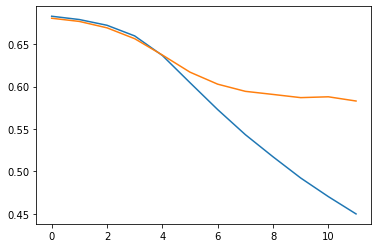

In [25]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

In [32]:
## checking accuracy
with torch.no_grad():
    sample_num = 0
    total = 0
    for inputs, targets in train_loader():
        inputs = torch.from_numpy(inputs).to(device)
        targets = torch.from_numpy(targets).to(device)
        preds = model(inputs)
        preds = preds > 0
        total += (preds == targets).sum().item()
        sample_num += inputs.size(0)

    train_acc = total/sample_num
    
    sample_num = 0
    total = 0
    for inputs, targets in test_loader():
        inputs = torch.from_numpy(inputs).to(device)
        targets = torch.from_numpy(targets).to(device)
        preds = model(inputs)
        preds = preds > 0
        total += (preds == targets).sum().item()
        sample_num += inputs.size(0)

    test_acc = total/sample_num

    print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.8199, Test Accuracy: 0.7097
